### set session

In [1]:
name = 'ANA1'
session = '20231211_d21'
num_trials = 143

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.select_trials import select_hit_trials
from common.make_percent_scaled import make_percent_scaled
from common.extract_movement_intervals import extract_movement_intervals
from jerk.get_jerks import get_jerks
from jerk.get_point_acceleration import get_point_acceleration

In [3]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

Velocity_folder = "../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"
PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

respMTX shape: (143, 7)
MTXTrialType shape: (1000, 5)
number of trials: 143


for mac:

In [4]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


for windows:

In [5]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


### An example window cutoff frequency calculation

In [6]:
samples = 201
f_sampling = 5888
M = (samples - 1) / 2
f_c=5 / (3.2*M - 4.6)
f_cutoff = f_c /2 *f_sampling
print('f_cutoff', f_cutoff, "Hz =", 1/(f_cutoff) *1000, 'ms')
print('200 Hz = 5 ms')
print('fastest movement: about', 1/50 * 1000, 'ms')

f_cutoff 46.6708941027267 Hz = 21.42663043478261 ms
200 Hz = 5 ms
fastest movement: about 20.0 ms


### calculate jerks for all trials

In [7]:
window_duration = 0.1
get_jerks(num_trials, window_duration, Velocity_folder, PreprocessLeverData_folder, output_folder)

calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per window:  588
calculated samples per windo

### Extract just the leverpress movement jerks

In [8]:
hit_movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
jerks = extract_movement_intervals(hit_movement_informations, 'jerk', output_folder, PreprocessLeverData_folder, output_folder)

plot

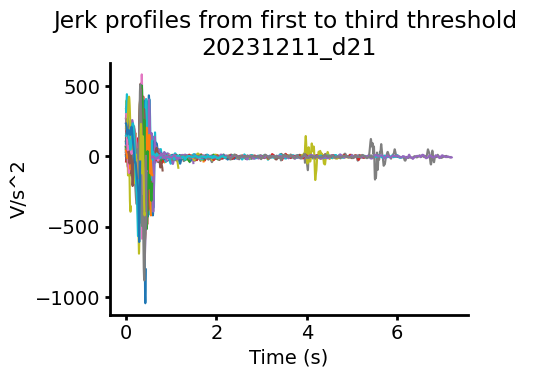

In [9]:
set_matplotlib_settings()

for jerk in jerks:
    plt.plot(jerk[0,:],jerk[1,:])
plt.xlabel("Time (s)")
plt.ylabel("V/s^2")
plt.title("Jerk profiles from first to third threshold \n"+session)
plt.show()

### Make completion scaled jerks

In [10]:
hit_trials = select_hit_trials(respMTX, num_trials)
num_interpolation_samples = 10*10000
jerks_percent_scaled = make_percent_scaled(hit_trials, num_interpolation_samples, 'jerkmovement', output_folder, output_folder)

101  hit trials in this session.
percent scaled shape:  (101, 100000)


plot

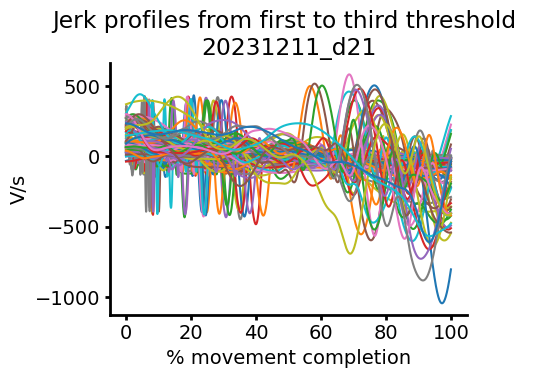

In [11]:
x_range = np.array(range(0,num_interpolation_samples)) * 100 / num_interpolation_samples
for jerk_percent_scaled in jerks_percent_scaled:
    plt.plot(x_range, jerk_percent_scaled)
plt.xlabel("% movement completion")
plt.ylabel("V/s")
plt.title("Jerk profiles from first to third threshold \n"+session)
plt.show()

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$

- solve boundary conditions


In [30]:
movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
movement_information = movement_informations[0]

trial_index = int(movement_information[0])
left_index, right_index = movement_information[1:]
left_index = int(left_index)
right_index = int(right_index)
index_a = left_index

leverdata = np.fromfile(PreprocessLeverData_folder+"processed_trial"+str(trial_index)+".bin", dtype=np.double)
index_b = np.argmax(leverdata[left_index:right_index+1]) + left_index

velocity = np.load(Velocity_folder+"velocity_trial"+str(trial_index)+".npy")

x_0 = leverdata[index_a]
v_0 = velocity[index_a]
a_0 = get_point_acceleration(trial_index, index_a, window_duration, Velocity_folder, PreprocessLeverData_folder)
print(x_0, v_0, a_0)

x_f = leverdata[index_b]
v_f = velocity[index_b]
a_f = get_point_acceleration(trial_index, index_b, window_duration, Velocity_folder, PreprocessLeverData_folder)
print(x_f, v_f, a_f)

sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
tf = sample_times[index_b] - sample_times[index_a]
print(tf)

calculated samples per window:  588
2.9332328480240983 79.6723725972163 -3.2355697727687365e+19
calculated samples per window:  588
3.427990916832458 9.518876325475402 2.534989360610994e+20
0.3647968929346632


In [31]:
from sympy import symbols, diff, Eq, solve

# Define the symbols
t, C1, C2, C3, C4, C5, C6 = symbols('t C1 C2 C3 C4 C5 C6')

# Define the expression for x(t)
x_t = C1 * t**5 + C2 * t**4 + C3 * t**3 + C4 * t**2 + C5 * t + C6

# Define expressions for v(t) and a(t)
v_t = diff(x_t, t)
a_t = diff(v_t, t)

# Set up the system of equations
equations = [
    Eq(x_t.subs(t, 0), x_0),
    Eq(v_t.subs(t, 0), v_0),
    Eq(a_t.subs(t, 0), a_0),
    Eq(x_t.subs(t, tf), x_f),
    Eq(v_t.subs(t, tf), v_f),
    Eq(a_t.subs(t, tf), a_f)
]

# Solve the system of equations
solution = solve(equations, (C1, C2, C3, C4, C5, C6))

# Display the solution
print("Solution for the coefficients:")
for coeff, value in solution.items():
    print(f"{coeff}: {value}")


Solution for the coefficients:
C1: 2.94416298938426E+21
C2: -2.26961080907413E+21
C3: 4.80494812365285E+20
C4: -1.61778488638437E+19
C5: 79.6723725972163
C6: 2.93323284802410


In [ ]:
jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)

### Calculate the minimum jerk from peak to end of movement